In [1]:
import numpy as np
from scipy.stats import pearsonr

import NPI

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"
    
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    
    return np.array(flattened)

### **NPI usage demo**

In [3]:
batch_size              = 100
train_set_proportion    = 0.9
ROI_num                 = 360
using_steps             = 3

In [4]:
signals = []; inputs = []; targets = []
signals.append(np.loadtxt('./real_fMRI_data/102008_REST1_LR.txt')[30:, :360]); inputs.append(NPI.multi2one(signals[-1], steps = using_steps)[0]); targets.append(NPI.multi2one(signals[-1], steps = using_steps)[1])
signals.append(np.loadtxt('./real_fMRI_data/102008_REST1_RL.txt')[30:, :360]); inputs.append(NPI.multi2one(signals[-1], steps = using_steps)[0]); targets.append(NPI.multi2one(signals[-1], steps = using_steps)[1])
signals.append(np.loadtxt('./real_fMRI_data/102008_REST2_LR.txt')[30:, :360]); inputs.append(NPI.multi2one(signals[-1], steps = using_steps)[0]); targets.append(NPI.multi2one(signals[-1], steps = using_steps)[1])
signals.append(np.loadtxt('./real_fMRI_data/102008_REST2_RL.txt')[30:, :360]); inputs.append(NPI.multi2one(signals[-1], steps = using_steps)[0]); targets.append(NPI.multi2one(signals[-1], steps = using_steps)[1])
signals = np.vstack(signals); inputs = np.vstack(inputs); targets = np.vstack(targets)

In [5]:
neworderlr = np.loadtxt('./Whole-brain_EC/MNI-MMP1/neworderlr.txt')
neworder = np.array([np.where(neworderlr == i)[0][0] for i in range(len(neworderlr))])
oldorder = np.array([np.where(neworder == i)[0][0] for i in range(len(neworder))])

##### train NN

Several ANNs (MLP, CNN, RNN, VAR) are provided in the NPI framework, which can be used as a surrogate brain.

In [6]:
ANN = NPI.ANN_MLP(input_dim = using_steps * ROI_num, hidden_dim = 2 * ROI_num, latent_dim = int(0.8 * ROI_num), output_dim = ROI_num)
# ANN = NPI.ANN_CNN(in_channels = ROI_num, hidden_channels = 3 * ROI_num, out_channels = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_RNN(input_dim = ROI_num, hidden_dim = int(2.5 * ROI_num), latent_dim = int(2.5 * ROI_num), output_dim = ROI_num, data_length = using_steps)
# ANN = NPI.ANN_VAR(input_dim = using_steps * ROI_num, output_dim = ROI_num)

ANN, training_loss, testing_loss = NPI.train_NN(ANN, inputs, targets, num_epochs = 100, lr = 1e-3, l2 = 5e-5)

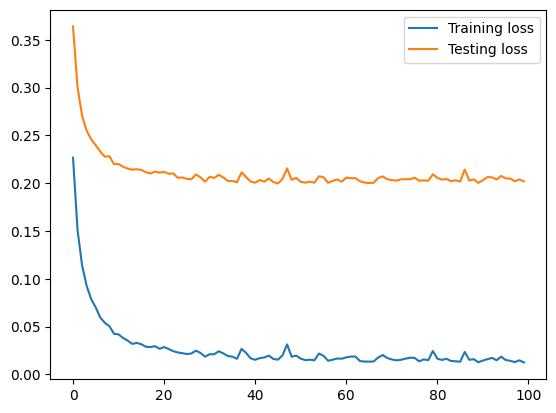

In [7]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

##### calculate empirical FC & model FC

In [8]:
empirical_FC = NPI.corrcoef(signals)
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

##### calculate NPI Inferred EC

In [9]:
NPI_EC = NPI.model_EC(ANN, inputs, targets, pert_strength = 1.0)
np.fill_diagonal(NPI_EC, 0)

##### empirical FC - model FC comparison

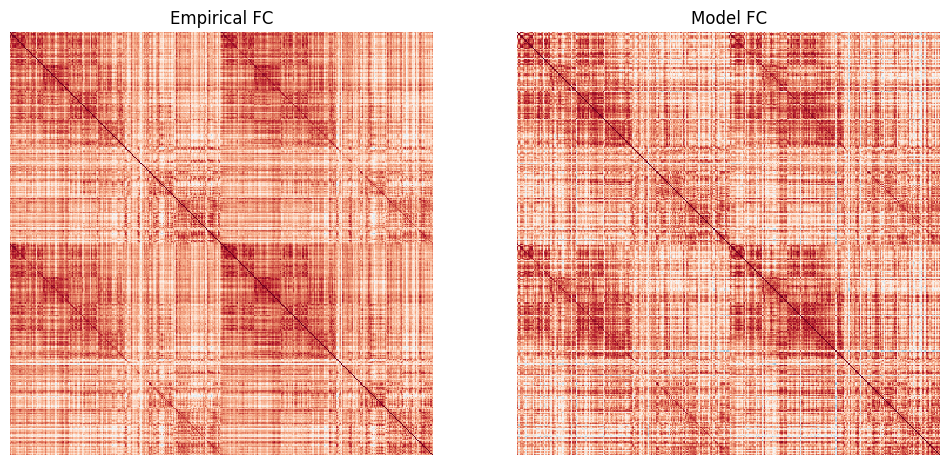

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC[neworder].T[neworder].T, ax = ax1, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC[neworder].T[neworder].T, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

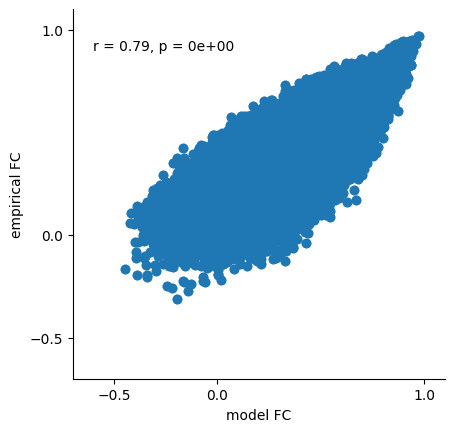

In [11]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-0.7, 1.1); plt.xticks([-0.5, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.7, 1.1); plt.yticks([-0.5, 0.0, 1.0]); plt.ylabel('empirical FC')
plt.text(-0.6, 0.9, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()

##### NPI EC (individual)

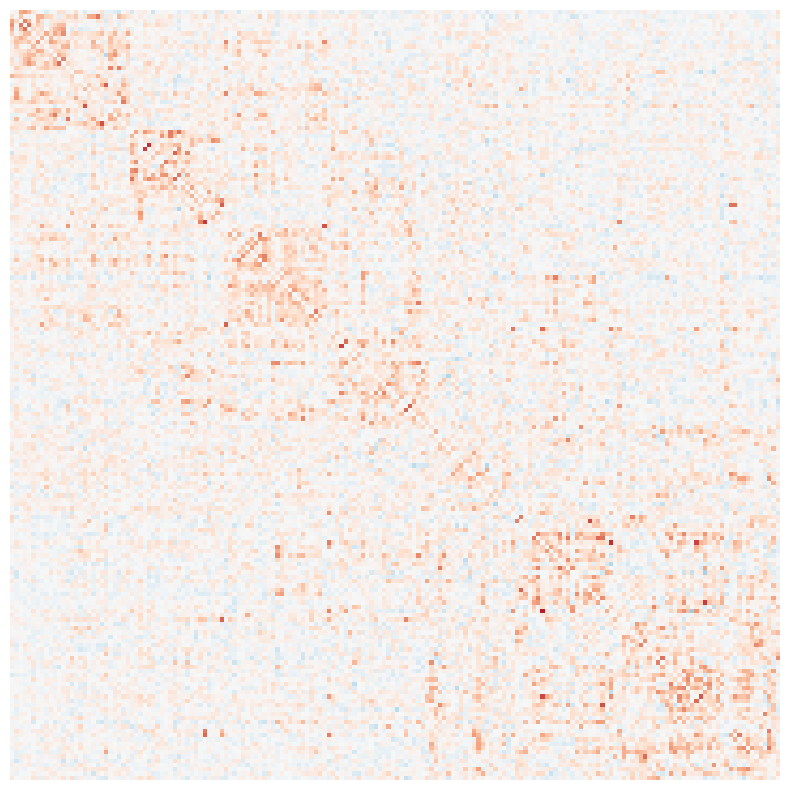

In [12]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(NPI_EC[neworder].T[neworder].T[:180, :180], vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
plt.show()